In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/jkrieger/work/ray_tracing/python')
import mantaray
import math

In [2]:
g = 9.8
def period2wavenumber(T):
    k = (2*np.pi)**2/g/T**2
    return k

def group_velocity(k):
    cg = 0.5*(g/k)**.5
    return cg

In [3]:
large_scale_rays = xr.load_dataset('larger_scale_refraction_rays.nc')
small_scale_rays = xr.load_dataset('larger_scale_refraction_rays.nc')
ww_2021 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/smode_data/WW3_SMODE_Pilot.nc')

In [4]:
start_date = '2021-10-30T11:00:00.000000000' # start date and time of front
end_date = '2021-10-30T22:00:00.000000000' # end date and time of front
ww_slice = ww_2021.sel(time=slice(start_date, end_date), longitude=slice(234.5, 237), latitude=slice(36.5,38.5))

In [5]:
ww_slice

<xarray.Dataset> Size: 3MB
Dimensions:    (longitude: 83, latitude: 67, time: 12)
Coordinates:
  * longitude  (longitude) float32 332B 234.5 234.6 234.6 ... 236.9 236.9 237.0
  * latitude   (latitude) float32 268B 36.5 36.53 36.56 ... 38.42 38.45 38.48
  * time       (time) datetime64[ns] 96B 2021-10-30T11:00:00 ... 2021-10-30T2...
Data variables: (12/13)
    MAPSTA     (latitude, longitude) int16 11kB 1 1 1 1 1 1 1 ... 1 0 0 0 0 0 0
    crs        |S1 1B b''
    ucur       (time, latitude, longitude) float32 267kB 0.1876 0.1851 ... nan
    vcur       (time, latitude, longitude) float32 267kB -0.1184 -0.1172 ... nan
    uwnd       (time, latitude, longitude) float32 267kB 6.524 6.492 ... nan nan
    vwnd       (time, latitude, longitude) float32 267kB -1.073 -1.023 ... nan
    ...         ...
    t0m1       (time, latitude, longitude) float32 267kB 9.248 9.281 ... nan nan
    fp         (time, latitude, longitude) float32 267kB 0.09232 0.09221 ... nan
    dir        (time, latitude, longitude) float32 267kB 309.0 309.1 ... nan nan
    dp         (time, latitude, longitude) float32 267kB 331.1 331.0 ... nan nan
    uuss       (time, latitude, longitude) float32 267kB 0.04654 0.04605 ... nan
    vuss       (time, latitude, longitude) float32 267kB -0.006698 ... nan
Attributes: (12/16)
    WAVEWATCH_III_version_number:     7.14
    WAVEWATCH_III_switches:           NOGRB SCRIP SCRIPNC TRKNC DIST MPI PR3 ...
    SIN4 namelist parameter BETAMAX:  1.42
    product_name:                     ww3.202110.nc
    area:                             GLOBAL GRID
    latitude_resolution:              0.
    ...                               ...
    easternmost_longitude:            240.
    minimum_altitude:                 -12000 m
    maximum_altitude:                 9000 m
    altitude_resolution:              n/a
    start_date:                       2021-10-01 00:00:00
    stop_date:                        2021-10-31 23:00:00

In [6]:
def haversine(coord1, coord2):
    '''
    This outputs the distance in meters between two lat/lon coordinates.
    '''
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [27]:
# Length of domain in meters
Lx = haversine((37.49, 234.52), (37.49, 236.98))
Ly = haversine((36.5, 234.52), (38.48, 234.52))

# grid spacing
dx = haversine((37.49, 234.52), (37.49, 234.55))
dy = haversine((36.5, 234.52), (36.53, 234.52))

# hs vals
hs = ww_slice.hs[0,:,:].values

y = np.arange(0, Ly+dy, dy)  # Ensures correct size
x = np.arange(0, Lx+dx, dx)  # Ensures correct size

Umax = np.nanmax(np.sqrt((ww_slice.ucur[0,:,:].values)**2+(ww_slice.vcur[0,:,:].values)**2))

nx, ny = len(x), len(y)

xc = np.linspace(0, 1, ny)
u = ww_slice.ucur[0,:,:].values
v = ww_slice.vcur[0,:,:].values

In [28]:
u

array([[0.1875557 , 0.18514358, 0.1917489 , ..., 0.20754668, 0.12516263,
        0.10225014],
       [0.24312752, 0.24510306, 0.24211435, ..., 0.11502384, 0.09374904,
        0.04587035],
       [0.26153123, 0.25890142, 0.26253325, ..., 0.0660824 , 0.04155603,
        0.03815508],
       ...,
       [0.07079457, 0.11914334, 0.20037124, ...,        nan,        nan,
               nan],
       [0.18024394, 0.16165535, 0.13551158, ...,        nan,        nan,
               nan],
       [0.27448446, 0.22904299, 0.20854236, ...,        nan,        nan,
               nan]], shape=(67, 83), dtype=float32)

In [29]:
v

array([[-0.11837015, -0.11716211, -0.11535531, ..., -0.38408267,
        -0.27080306, -0.29209957],
       [-0.09600575, -0.09786664, -0.10535982, ..., -0.26707163,
        -0.25671571, -0.26980975],
       [-0.03253098, -0.04149658, -0.03971334, ..., -0.25004983,
        -0.28813174, -0.23380546],
       ...,
       [-0.22950198, -0.24041708, -0.2284016 , ...,         nan,
                nan,         nan],
       [-0.14721875, -0.18993507, -0.23705636, ...,         nan,
                nan,         nan],
       [-0.05998105, -0.07980594, -0.12500831, ...,         nan,
                nan,         nan]], shape=(67, 83), dtype=float32)

In [30]:
ds = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "hs": (["y", "x"], hs, {"long_name": "hs", "units": "m"}),
        "u": (["y", "x"], u, {"long_name": "u", "units": "m/s"}),
        "v": (["y", "x"], v, {"long_name": "v", "units": "m/s"}),
    })

In [31]:
ds.hs

<xarray.DataArray 'hs' (y: 67, x: 83)> Size: 22kB
array([[1.4866902, 1.4849589, 1.48454  , ..., 1.6987008, 1.6905385,
        1.6932472],
       [1.4696798, 1.4715438, 1.4764622, ..., 1.6921543, 1.7014811,
        1.7006743],
       [1.4707023, 1.4712852, 1.4758654, ..., 1.7077924, 1.7115545,
        1.7087631],
       ...,
       [1.6468546, 1.6463296, 1.6447395, ...,       nan,       nan,
              nan],
       [1.6591196, 1.6588639, 1.6579077, ...,       nan,       nan,
              nan],
       [1.6750066, 1.6698691, 1.6591043, ...,       nan,       nan,
              nan]], shape=(67, 83), dtype=float32)
Coordinates:
  * x        (x) float64 664B 0.0 2.648e+03 5.295e+03 ... 2.145e+05 2.171e+05
  * y        (y) float64 536B 0.0 3.337e+03 6.674e+03 ... 2.169e+05 2.202e+05
Attributes:
    long_name:  hs
    units:      m

# Initialize wave parameters

In [20]:
# Period of incident waves in seconds
T0 = 11
# Direction of incident waves in radians (trig convention, going to)
theta_deg = 306.4
theta0 = theta_deg * (np.pi/180)
# Convert period to wavenumber magnitude
k0 = period2wavenumber(T0)
# Calculate wavenumber components
kx0 = k0*np.cos(theta0)
ky0 = k0*np.sin(theta0)

# Number of rays
n_rays = 100
# Initialize wavenumber for all rays
Kx0 = kx0*np.ones(n_rays)
Ky0 = ky0*np.ones(n_rays)

# Current and bathymetry file path
bathymetry = 'data/bathymetry/bathy_zonal_jet.nc'
current = 

x = ds.x.values
y = ds.y.values

# Creates initial x position for all rays
x0 = 10*np.ones(n_rays)
y0 = np.linspace(0, y.max(), n_rays)

# Estimates CFL
# Computes grid smallest spacing
dd = np.min([np.diff(x).mean(), np.diff(y).mean()])
# Computes group velocity
cg = group_velocity(k0)
# Computes CFL
cfl = dd/cg

duration = round(x.max()/cg)
step_size = cfl

# Initialize ray tracing and ray positions

In [21]:
x0 = np.linspace(0, 200, num=100)  # 100 rays spread from 0 to 200 in x
y0 = np.full_like(x0, 220)  # Set y positions at 220
#bundle = mantaray.ray_tracing(x0, y0, Kx0, Ky0, duration, step_size, bathymetry, current)

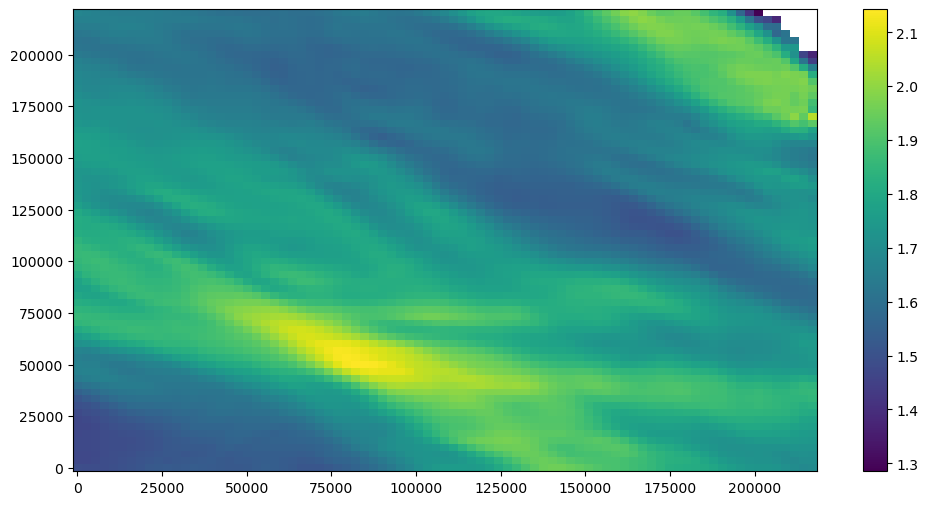

In [32]:
X = ds.x
Y = ds.y
hs = ds.hs
plt.figure(figsize=(12, 6))
cs = plt.pcolormesh(X, Y, hs)
'''
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    plt.plot(ray.x, ray.y, 'red', lw=.78)
'''
#plt.scatter(sd_x_meters, sd_y_meters, c=non_masked, marker='o', label='SD 1062 data')
#plt.legend(loc='upper right')
plt.colorbar(cs)